In [40]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import urllib.request
import warnings
warnings.filterwarnings("ignore")

In [41]:
images = [
    'https://raw.githubusercontent.com/xingyizhou/CenterNet/master/images/16004479832_a748d55f21_k.jpg',
    'https://raw.githubusercontent.com/xingyizhou/CenterNet/master/images/17790319373_bd19b24cfc_k.jpg',
    'https://raw.githubusercontent.com/xingyizhou/CenterNet/master/images/18124840932_e42b3e377c_k.jpg',
    'https://raw.githubusercontent.com/xingyizhou/CenterNet/master/images/33887522274_eebd074106_k.jpg',
    # 'https://farm7.staticflickr.com/6073/6032446158_85fa667cd2_z.jpg',
    # 'https://farm9.staticflickr.com/8538/8678472399_886f8eabec_z.jpg',
    # 'https://farm6.staticflickr.com/5485/10028794463_d8cbb38932_z.jpg',
    # 'https://farm4.staticflickr.com/3057/2475401198_0a342a907e_z.jpg'
]

img_list = []
for i, url in enumerate(images):
    filename = f'img{i+1}.jpg'
    urllib.request.urlretrieve(url, filename)
    img = cv2.imread(filename)
    img_list.append(img)

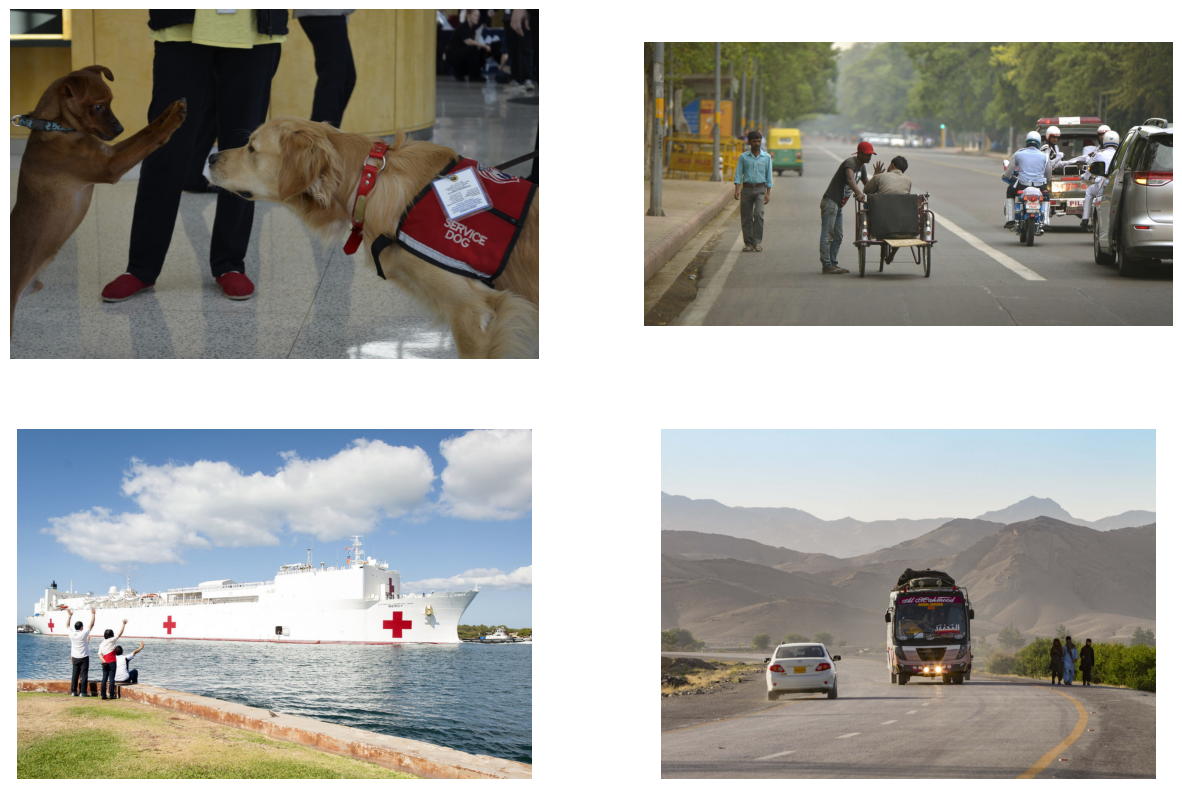

In [42]:
def plot_images(img_list, titles=None, rows=1, cols=2, fig_size=(15, 10)):
    plt.figure(figsize=fig_size)
    for i, img in enumerate(img_list):
        plt.subplot(rows, cols, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        if titles:
            plt.title(titles[i])
    plt.show()

plot_images(img_list, rows=2, cols=2, fig_size=(15, 10))

In [43]:
category_index = {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle',
                  5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat',
                  10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign',
                  14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat',
                  18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow',
                  22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe',
                  27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie',
                  33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard',
                  37: 'sports ball', 38: 'kite', 39: 'baseball bat',
                  40: 'baseball glove', 41: 'skateboard', 42: 'surfboard',
                  43: 'tennis racket', 44: 'bottle', 46: 'wine glass',
                  47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl',
                  52: 'banana',  53: 'apple',  54: 'sandwich',  55: 'orange',
                  56: 'broccoli',  57: 'carrot',  58: 'hot dog',  59: 'pizza',
                  60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch',
                  64: 'potted plant', 65: 'bed', 67: 'dining table',
                  70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse',
                  75: 'remote', 76: 'keyboard', 77: 'cell phone',
                  78: 'microwave', 79: 'oven', 80: 'toaster', 81: 'sink',
                  82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase',
                  87: 'scissors', 88: 'teddy bear', 89: 'hair drier',
                  90: 'toothbrush'}

R = np.arange(0, 256, 63)
G = np.roll(R, 2)
B = np.roll(R, 4)
COLOR_IDS = np.array(np.meshgrid(R, G, B)).T.reshape(-1, 3)

In [ ]:
model_url = 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1'
model = hub.load(model_url)
print("Модель завантажена")


In [45]:
def process_predictions(predictions, img, score_thresh=0.3):
    bboxes = predictions['detection_boxes'][0].numpy()
    scores = predictions['detection_scores'][0].numpy()
    classes = predictions['detection_classes'][0].numpy().astype(int)

    mask = scores >= score_thresh
    bboxes, scores, classes = bboxes[mask], scores[mask], classes[mask]

    h, w, _ = img.shape
    bboxes[:, 0] *= h
    bboxes[:, 1] *= w
    bboxes[:, 2] *= h
    bboxes[:, 3] *= w

    return bboxes.astype(int), scores, classes

def draw_predictions(img, bboxes, scores, classes):
    img_with_boxes = img.copy()

    for box, score, cls in zip(bboxes, scores, classes):
        y1, x1, y2, x2 = box
        if cls in category_index:
            class_name = category_index[cls]
        else:
            class_name = f"Class {cls}"

        color = tuple(COLOR_IDS[cls % len(COLOR_IDS)].tolist())[::-1]

        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)

        label = f"{class_name}: {score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        cv2.rectangle(img_with_boxes, (x1, y1 - text_height - 5),
                     (x1 + text_width, y1), color, -1)

        cv2.putText(img_with_boxes, label, (x1, y1 - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return img_with_boxes

In [46]:
all_predictions = []

for i, img in enumerate(img_list):
    img_tensor = tf.convert_to_tensor(np.array([img]))

    predictions = model(img_tensor)

    bboxes, scores, classes = process_predictions(predictions, img)

    annotated_img = draw_predictions(img, bboxes, scores, classes)
    all_predictions.append(annotated_img)

    print(f"Зображення {i+1}: знайдено {len(bboxes)} об'єктів")

Зображення 1: знайдено 8 об'єктів
Зображення 2: знайдено 17 об'єктів
Зображення 3: знайдено 9 об'єктів
Зображення 4: знайдено 10 об'єктів


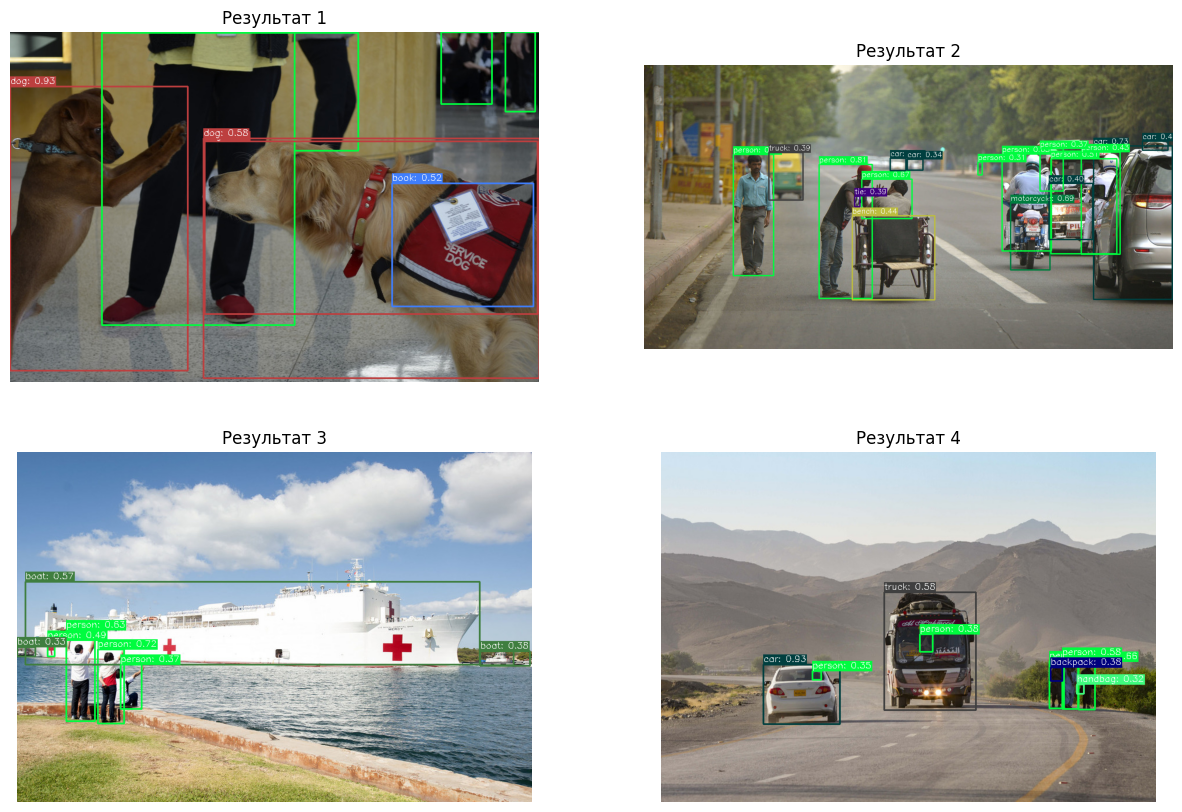

In [47]:
plot_images(all_predictions,
           titles=['Результат 1', 'Результат 2', 'Результат 3', 'Результат 4'],
           rows=2, cols=2, fig_size=(15, 10))
